<a href="https://colab.research.google.com/github/rodrigo0345/Aprof2/blob/main/PreProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def load_mp4(file_path, resize_dim=(224, 224), num_frames=None, to_rgb=True):
    # Open the video file
    cap = cv2.VideoCapture(file_path)

    if not cap.isOpened():
        raise ValueError(f"Error: Could not open video file {file_path}")

    frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess frame
        if resize_dim:
            frame = cv2.resize(frame, resize_dim)
        if to_rgb:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        frames.append(frame)
        frame_count += 1

        # Stop if num_frames is specified
        if num_frames and frame_count >= num_frames:
            break

    cap.release()

    # Convert to NumPy array
    frames = np.array(frames)  # Shape: (num_frames, height, width, channels)

    return frames

# Example usage
file_path = "A31H.mp4"
frames = load_mp4(file_path, resize_dim=(1920, 1080), num_frames=16, to_rgb=True)
print(f"Loaded {len(frames)} frames with shape {frames[0].shape}")

Loaded 16 frames with shape (1080, 1920, 3)


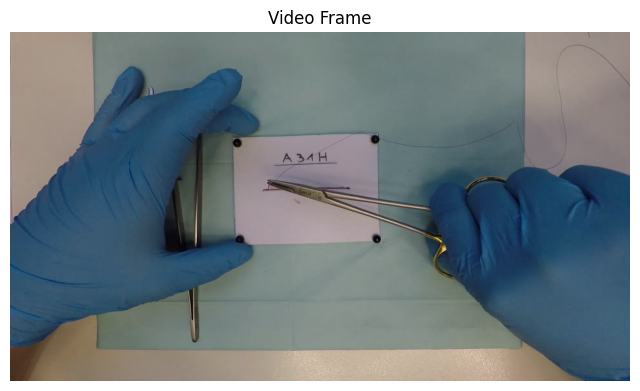

In [28]:
def display_single_frame(frame):
    plt.figure(figsize=(8, 6))
    plt.imshow(frame)
    plt.axis('off')  # Hide axes
    plt.title('Video Frame')
    plt.show()

test_frame = frames[5]
display_single_frame(test_frame)

In [67]:
def apply_edge_filters(frame_gray):
    # 1. Canny Edge Detector
    canny = cv2.Canny(frame_gray, threshold1=100, threshold2=200)

    # 2. Sobel Filter
    sobel_x = cv2.Sobel(frame_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(frame_gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)  # Combine x and y gradients
    sobel = np.uint8(np.clip(sobel, 0, 255))  # Convert to 8-bit
    _, sobel_binary = cv2.threshold(sobel, 40, 255, cv2.THRESH_BINARY)

    # 3. Laplacian Filter
    laplacian = cv2.Laplacian(frame_gray, cv2.CV_64F)
    laplacian = np.uint8(np.clip(np.abs(laplacian), 0, 255))  # Convert to 8-bit

    # 4. Prewitt Filter
    kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=np.float32)
    kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=np.float32)
    prewitt_x = cv2.filter2D(frame_gray, cv2.CV_64F, kernel_x)
    prewitt_y = cv2.filter2D(frame_gray, cv2.CV_64F, kernel_y)
    prewitt = np.sqrt(prewitt_x**2 + prewitt_y**2)
    prewitt = np.uint8(np.clip(prewitt, 0, 255))

    # 5. Roberts Cross Operator
    roberts_kernel_x = np.array([[1, 0], [0, -1]], dtype=np.float32)
    roberts_kernel_y = np.array([[0, 1], [-1, 0]], dtype=np.float32)
    roberts_x = cv2.filter2D(frame_gray, cv2.CV_64F, roberts_kernel_x)
    roberts_y = cv2.filter2D(frame_gray, cv2.CV_64F, roberts_kernel_y)
    roberts = np.sqrt(roberts_x**2 + roberts_y**2)
    roberts = np.uint8(np.clip(roberts, 0, 255))

    return {
        'Canny': canny,
        'Sobel': sobel_binary,
        'Laplacian': laplacian,
        'Prewitt': prewitt,
        'Roberts': roberts
    }

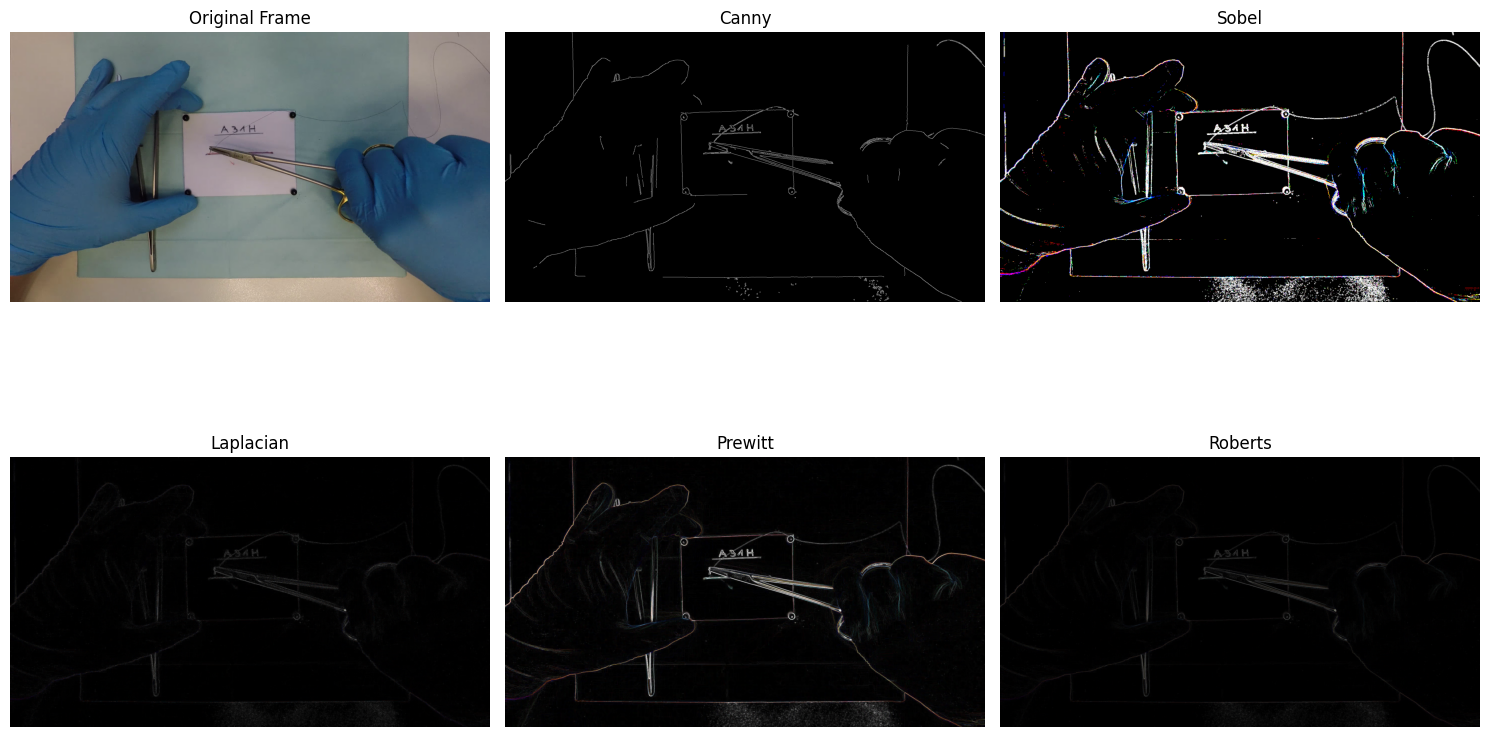

In [68]:
def display_frames(original_frame, filtered_frames):
    # Create a grid of subplots (original + 5 filtered images)
    plt.figure(figsize=(15, 10))

    # Original frame
    plt.subplot(2, 3, 1)
    plt.imshow(original_frame)
    plt.title('Original Frame')
    plt.axis('off')

    # Filtered frames
    for i, (name, filtered) in enumerate(filtered_frames.items(), 2):
        plt.subplot(2, 3, i)
        plt.imshow(filtered, cmap='gray')
        plt.title(name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

filtered_frames = apply_edge_filters(frames[11])

# Display results
display_frames(test_frame, filtered_frames)

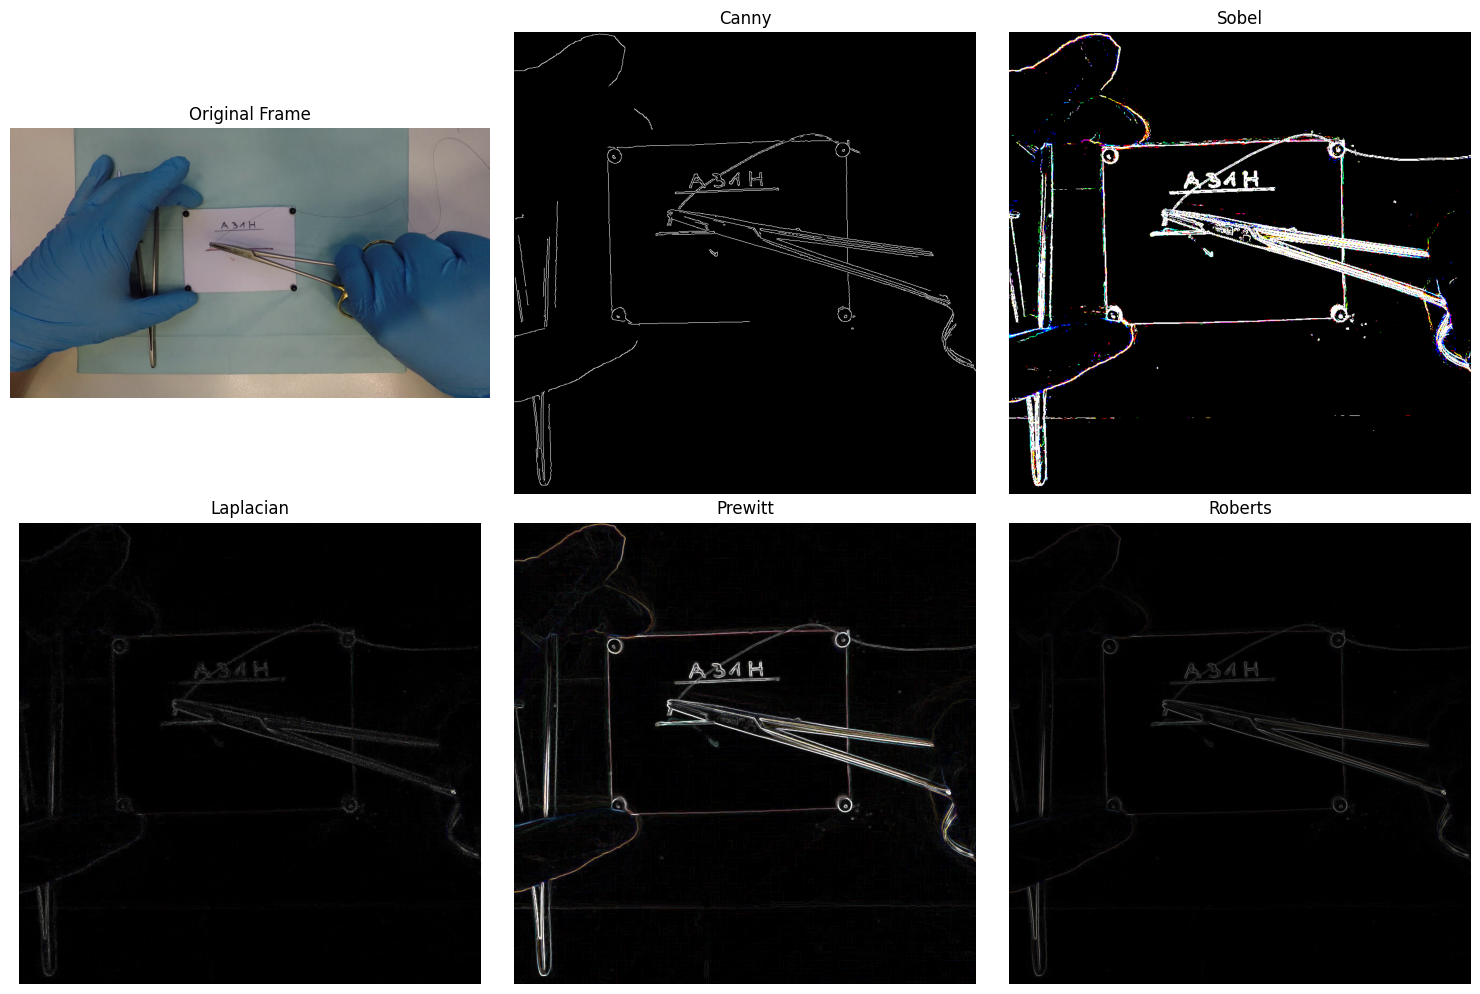

In [78]:
def crop_center(image, crop_fraction=0.5):

    if len(image.shape) == 3:
        height, width, _ = image.shape
    else:
        height, width = image.shape

    crop_height = int(height * crop_fraction)
    crop_width = int(width * crop_fraction)

    crop_size = min(crop_height, crop_width)

    if crop_size % 2 != 0:
        crop_size -= 1

    center_y, center_x = height // 2, width // 2

    y1 = center_y - crop_size // 2
    y2 = center_y + crop_size // 2
    x1 = center_x - crop_size // 2
    x2 = center_x + crop_size // 2

    y1 = max(0, y1)
    y2 = min(height, y2)
    x1 = max(0, x1)
    x2 = min(width, x2)

    if len(image.shape) == 3:
        cropped = image[y1:y2, x1:x2, :]
    else:
        cropped = image[y1:y2, x1:x2]

    return cropped

cropped_image = crop_center(frames[11], 0.8)
filtered_frames = apply_edge_filters(cropped_image)
display_frames(test_frame, filtered_frames)